In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import (
    setup_plotting_env,
    geno_palette,
    syllable_aliases,
    lighten_color,
    clean_ticks,
    savefig
)
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from scipy.stats import mannwhitneyu

import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
aliases = {
    "change_count_cumulative_within_session_v2": "Change in\n target counts",
    "change_count_cumulative_v2": "Change in\n target counts (cumulative)",
    "log2_fold_change_count_cumulative_v2": "log2(fold) change\n in target counts (cumulative)",
    "log2_fold_change_count_cumulative_within_session_v2": "log2(fold) change\n in target counts",
}

In [4]:
import toml
with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

In [6]:
syllable_classes = toml.load(os.path.join(proc_dirs["closed_loop_behavior"], "behavior_classes.toml"))
syllable_map = {}
for k, v in syllable_classes.items():
    for _syllable in v:
        syllable_map[_syllable] = k

In [7]:
test_statistics_file = os.path.join(
    proc_dirs["closed_loop_behavior"], "stats_closed_loop_behavior.toml"
)

In [8]:
bin_size = closed_loop_cfg["learning_timecourse"]["bin_size"]

In [9]:
test_stats = defaultdict(dict)

# Load in data

In [10]:
use_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"], "learning_timecourse_processed.parquet"
    )
)
use_df = use_df.loc[
    (use_df["syllable"] == use_df["target_syllable"]) & (use_df["rle"] == True)
].copy()

In [11]:
# save values off for models and such...

# Show the "short" timecourse

In [12]:
cum_df_plt = use_df.copy()
cum_df_plt.loc[cum_df_plt["session_number"].mod(2) == 0, "bin_start"] += 1800

max_bins = cum_df_plt.groupby("session_number")["bin_start"].max()

nbins = use_df["bin_start"].nunique()

bins = cum_df_plt["bin_start"].unique()
bin_map = dict(list(zip(bins, np.arange(len(bins)) + 1)))

# insert a nan to make a break in the relplot
plt_line = cum_df_plt.set_index(
    ["session_type", "bin_start", "syllable_group_unique", "mouse_id", "area", "opsin"]
)
plt_line = plt_line.loc[["pre", "stim", "post"]]

## Get learners and plot mouse/syllable specific timecourses

In [13]:
threshold_variables = [
    "change_count_cumulative_v2",
]

In [14]:
bins = plt_line.index.get_level_values("bin_start").unique()
bin_map = dict(list(zip(bins, np.arange(len(bins)))))
max_bin = cum_df_plt.groupby("session_number")["bin_start"].max()
nbins = cum_df_plt["bin_start"].nunique()

In [15]:
mouse_curves = (
    plt_line.loc[plt_line.index.get_level_values("bin_start") <= np.inf]
    .loc["stim"]
    .groupby(["area", "mouse_id", "opsin", "bin_start"])
    .mean(numeric_only=True)
)

In [16]:
mouse_ints = mouse_curves.xs(max_bins.loc[2], level="bin_start")[threshold_variables]

In [17]:
threshold = mouse_ints.xs(("ctrl", "ctrl"), level=("area", "opsin")).quantile(1)
learners = mouse_ints > threshold

all_use_mice = learners.loc[learners.any(axis=1)].index.get_level_values("mouse_id")
use_mice = (
    learners.loc[learners.any(axis=1)]
    .xs(("snc (axon)", "chr2"), level=("area", "opsin"))
    .index.get_level_values("mouse_id")
)

meta_df = use_df.drop_duplicates("mouse_id").set_index("mouse_id")["sex"]
areas = learners.index.get_level_values("area").unique()

In [18]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "closed_loop_learners.toml"), "w"
) as f:
    learners_dct = {}
    for _area in areas:
        try:
            _area_learners = (
                learners.loc[learners.any(axis=1)]
                .xs(_area, level="area")
                .index.get_level_values("mouse_id")
                .tolist()
            )
        except KeyError:
            continue
        learners_dct[_area] = {
            "learners": _area_learners,
            "nlearners": len(_area_learners),
            "ntotal": mouse_curves.xs(_area, level="area")
            .index.get_level_values("mouse_id")
            .nunique(),
        }
    toml.dump(learners_dct, f)

In [19]:
plt_line["learner"] = plt_line.index.get_level_values("mouse_id").isin(use_mice)
plt_line["learner"] = plt_line["learner"].map({True: "yes", False: "no"})
plt_line.loc[plt_line.index.get_level_values("area") == "ctrl", "learner"] = "ctrl"

In [20]:
meta_df = plt_line.groupby("mouse_id").first()["learner"]
pal = meta_df.map(
    {
        "yes": geno_palette.snc,
        "no": lighten_color(geno_palette.snc, 0.5),
        "ctrl": geno_palette.ctrl,
    }
).tolist()
hue_order = meta_df.index

In [21]:
plt_variable = "change_count_cumulative_v2"

In [22]:
kwargs = {
    "x": "bin_start",
    "ci": 68,
    "y": plt_variable,
    "sort": False,
    "hue_order": hue_order,
    "palette": pal,
    "hue": "mouse_id",
    "lw": 1,
    "estimator": None,
    "legend": False,
    "clip_on": False,
}

In [23]:
setup_plotting_env()

/tmp/ipykernel_1655475/1942809674.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1655475/1942809674.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1655475/1942809674.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1655475/1942809674.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(


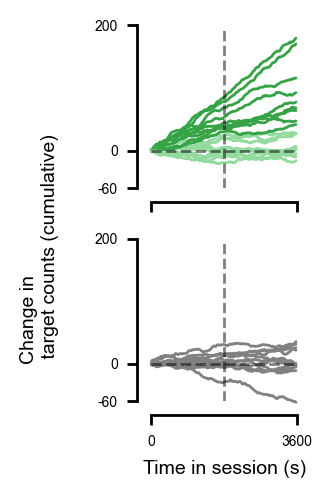

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(1.6, 2.5), sharex=True, sharey=True)

for (_ax, _area) in zip(ax, ["snc (axon)", "ctrl"]):
    sns.lineplot(
        data=plt_line.loc[
            (plt_line["session_number"] == 1)
            & (plt_line.index.get_level_values("opsin").isin(["chr2", "ctrl"]))
        ]
        .groupby(["area", "mouse_id", "learner", "bin_start"])
        .mean(numeric_only=True)
        .loc[_area]
        .sort_index(),
        ax=_ax,
        **kwargs,
    )

    sns.lineplot(
        data=plt_line.loc[
            (plt_line["session_number"] == 2)
            & (plt_line.index.get_level_values("opsin").isin(["chr2", "ctrl"]))
        ]
        .groupby(["area", "mouse_id", "learner", "bin_start"])
        .mean(numeric_only=True)
        .loc[_area]
        .sort_index(),
        ax=_ax,
        **kwargs,
    )
    _ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"], ls="--", alpha=0.5)
    _ax.axvline(x=1800, color=plt.rcParams["axes.edgecolor"], ls="--", alpha=0.5)
    _ax.set_ylabel("")
_ax.set_xlim(0, 3600)

if "usage" in plt_variable:
    _ax.set_ylim(0, 2)
elif "count" in plt_variable:
    _ax.set_ylim(-60, 200)
# ax.set_ylim(0,2)
_ax.set_xlabel("Time in session (s)")
fig.supylabel(aliases.get(plt_variable), fontsize=7)
sns.despine(offset=5)

clean_ticks(_ax, "x", precision=-2, zero_symmetry=False, dtype=int)
clean_ticks(_ax, "y", precision=1, zero_symmetry=False, dtype=int)
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"reinforcement_timecourse-{plt_variable}"),
    bbox_inches="tight",
)

## All syllables – learners only

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeist

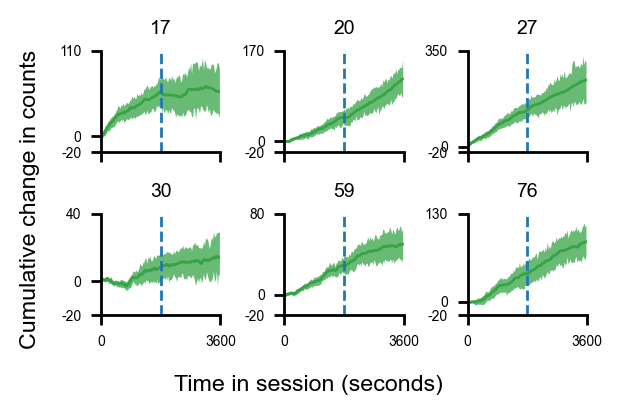

In [25]:
g = sns.relplot(
    data=plt_line.loc[plt_line.index.get_level_values("mouse_id").isin(use_mice)]
    .xs(("snc (axon)", "stim"), level=("area", "session_type"))
    .groupby(["mouse_id", "target_syllable", "bin_start"])
    .mean(numeric_only=True)
    .reset_index(),
    x="bin_start",
    y="change_count_cumulative",
    col="target_syllable",
    col_wrap=3,
    col_order=[17, 20, 27, 30, 59, 76],
    color=geno_palette.snc,
    kind="line",
    n_boot=100,
    ci=68,
    err_kws={"alpha": 0.75, "edgecolor": None, "lw": 0},
    estimator=np.mean,
    height=1,
    aspect=1,
    facet_kws={"sharey": False},
)
g.fig.axes[0].set_xlim(0, 3600)
clean_ticks(g.fig.axes[0], "x", dtype=int, precision=-2, zero_symmetry=False)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("", "")
g.fig.supxlabel("Time in session (seconds)")
for _ax in g.axes.flat:
    ylimits = _ax.get_ylim()
    if "log2" not in plt_variable:
        _ax.set_ylim(-15, ylimits[1])
        clean_ticks(_ax, "y", precision=-1, dtype=int, zero_symmetry=False)
    _ax.axvline(x=1800, ls="--")
if "log2" in plt_variable:
    g.fig.supylabel("Cumulative fold-change")
else:
    g.fig.supylabel("Cumulative change in counts")
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"reinforcement_timecourse_per-syllable_learners-only-{plt_variable}",
    ),
    bbox_inches="tight",
)

# Show change over baseline, non-cumulative

In [26]:
cum_df = use_df.loc[
    (use_df["stim_duration"] == 0.25)
    & (use_df["rle"] == True)
    & (use_df["syllable"] == use_df["target_syllable"])
    & (use_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

In [27]:
session_count = (
    cum_df
    .drop_duplicates(["mouse_id", "cohort", "target_syllable", "session_number"])
    .groupby(["mouse_id", "cohort", "target_syllable"])
    .size()
)
include_tups = session_count[session_count >= 6].index
cum_df = cum_df.set_index(include_tups.names).loc[include_tups].reset_index()

mouse_count = (
    cum_df.drop_duplicates(["mouse_id", "cohort", "target_syllable"])
    .groupby(["mouse_id", "cohort"])
    .size()
)
include_mice = mouse_count[mouse_count >= 3].index.tolist()
cum_df = (cum_df.set_index(["mouse_id", "cohort"]).loc[include_mice]).reset_index()

In [28]:
cum_df = cum_df.sort_values(
    [
        "syllable_group_unique",
        "session_number",
        "bin_start",
    ]
)

In [29]:
nbins = cum_df["bin_start"].nunique()

In [30]:
cum_df_plt = cum_df.copy()
cum_df_plt.loc[cum_df_plt["session_number"].mod(2) == 0, "bin_start"] += 1800

In [31]:
# insert a nan to make a break in the relplot
plt_line_noncum = cum_df_plt.groupby(
    [
        "bin_start",
        "mouse_id",
        "area",
        "session_type",
        "target_syllable",
        "stim_duration",
    ]
).mean()
plt_line_noncum = plt_line_noncum.loc[:, :, :, ["pre", "stim", "post"]]

# this inserts a break by inserting a new timepoint that we'll set to np.inf
old_idx = plt_line_noncum.index.to_frame()
old_idx.loc[:, "bin_start"] = 1750
old_idx = old_idx.drop_duplicates()

to_insert = pd.DataFrame(
    {"change_count": np.inf}, index=pd.MultiIndex.from_frame(old_idx)
)

plt_line_noncum = plt_line_noncum.append(to_insert)
plt_line_noncum = plt_line_noncum.sort_index()

mouse_curves = (
    plt_line_noncum.xs(("stim"), level=("session_type"))
    .groupby(["bin_start", "area", "mouse_id"])
    .mean()
)

plt_line_noncum["learner"] = plt_line_noncum.index.get_level_values("mouse_id").isin(use_mice)
plt_line_noncum["learner"] = plt_line_noncum["learner"].map({True: "yes", False: "no"})
plt_line_noncum.loc[plt_line_noncum.index.get_level_values("area") == "ctrl", "learner"] = "ctrl"

/tmp/ipykernel_1655475/739076749.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()
/tmp/ipykernel_1655475/739076749.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  old_idx.loc[:, "bin_start"] = 1750
/tmp/ipykernel_1655475/739076749.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt_line_noncum = plt_line_noncum.append(to_insert)


In [32]:
meta_df = plt_line_noncum.reset_index().drop_duplicates("mouse_id").set_index("mouse_id")["learner"]
pal = meta_df.map(
    {
        "yes": geno_palette.snc,
        "no": lighten_color(geno_palette.snc, 0.5),
        "ctrl": geno_palette.ctrl,
    }
).tolist()

In [33]:
hue_order = meta_df.index

In [34]:
setup_plotting_env()

In [35]:
plt_variable = "change_count"

In [36]:
pal = {
    "yes": geno_palette.snc,
    "no": lighten_color(geno_palette.snc, 0.5),
    "ctrl": geno_palette.ctrl,
}

/tmp/ipykernel_1655475/3323378185.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.ewm(halflife=1.5, adjust=True).mean())
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


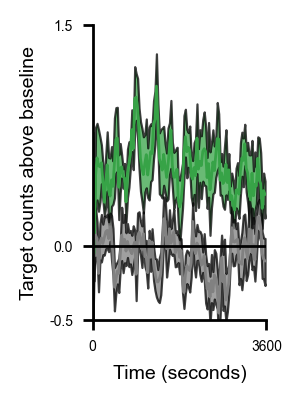

In [37]:
g = sns.relplot(
    data=plt_line_noncum.xs("stim", level="session_type")
    .groupby(["mouse_id", "area", "learner", "bin_start"])
    .median(numeric_only=True)
    .groupby(["mouse_id", "area", "learner"])
    .apply(lambda x: x.ewm(halflife=1.5, adjust=True).mean())
    .sort_index(),
    #     .reset_index().sort_values(["mouse_id","area","bin_start"]),
    x="bin_start",
    y=plt_variable,
    # sort=False,
    hue="learner",
    hue_order=["yes", "ctrl"],
    kind="line",
    n_boot=100,
    # col="area",
    # col_order=["snc (axon)", "ctrl"],
    palette=pal,
    lw=1,
    ci=68,
    legend=False,
    height=1.5,
    err_kws={"alpha": 0.75, "ec": "k"},
    aspect=0.75,
)
g.fig.set_size_inches(1.5, 2)
g.refline(y=0, zorder=100, lw=1, linestyle="-", color=plt.rcParams["axes.edgecolor"])
g.set_titles(col_template="{col_name}")
plt.ylabel("Target counts above baseline")
plt.xlabel("Time (seconds)")
plt.xlim(0, 3600)
plt.ylim(-0.5, 1.5)
clean_ticks(g.ax, "y", precision=2, zero_symmetry=False)
clean_ticks(g.ax, "x", precision=0, dtype=int, zero_symmetry=False)
# savefig(g.fig, os.path.join(figure_cfg["store_dir"], f"reinforcement_timecourse_delta_grouped-learners-{plt_variable}"), bbox_inches="tight")

In [38]:
plt_line = plt_line.sort_index()

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


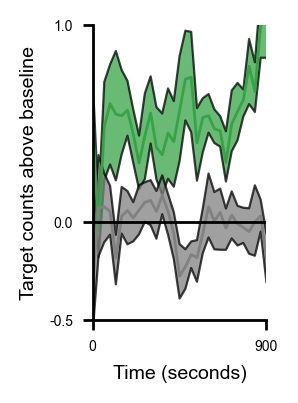

In [39]:
g = sns.relplot(
    data=plt_line_noncum.xs("stim", level="session_type")
    # .loc[1:]
    .groupby(["mouse_id", "area", "learner", "bin_start"], group_keys=False)
    .median(numeric_only=True)
    .groupby(["mouse_id", "area", "learner"], group_keys=False)
    .apply(lambda x: x.ewm(halflife=1.5, adjust=True).mean(numeric_only=True))
    .sort_index(),
    #     .reset_index().sort_values(["mouse_id","area","bin_start"]),
    x="bin_start",
    y=plt_variable,
    # sort=False,
    hue="learner",
    hue_order=["yes", "ctrl"],
    kind="line",
    n_boot=100,
    # col="area",
    # col_order=["snc (axon)", "ctrl"],
    palette=pal,
    lw=1,
    ci=68,
    legend=False,
    height=1.5,
    err_kws={"alpha": 0.75, "ec": "k"},
    aspect=0.75,
)
g.fig.set_size_inches(1.5, 2)
g.refline(y=0, zorder=100, lw=1, linestyle="-", color=plt.rcParams["axes.edgecolor"])
g.set_titles(col_template="{col_name}")
plt.ylabel("Target counts above baseline")
plt.xlabel("Time (seconds)")
plt.xlim(0, 900)
plt.ylim(-0.5, 1)
clean_ticks(g.ax, "y", precision=2, zero_symmetry=False)
clean_ticks(g.ax, "x", precision=0, dtype=int, zero_symmetry=False)
savefig(g.fig, os.path.join(figure_cfg["store_dir"], f"reinforcement_timecourse_delta_grouped-learners-{plt_variable}_zoom"), bbox_inches="tight")

## Show aggregate learning

In [40]:
cum_df = use_df[
    (use_df["syllable"] == use_df["target_syllable"])
    & (use_df["stim_duration"] == 0.25)
    & (use_df["opsin"].isin(["chr2", "ctrl"]))
].copy()

In [41]:
cum_df_plt = cum_df.copy()
cum_df_plt.loc[cum_df_plt["session_number"].mod(2) == 0, "bin_start"] += 1800

In [42]:
_plt_data = (
    cum_df_plt.loc[(cum_df_plt["bin_start"] >= (cum_df_plt["bin_start"].max()))]
    .groupby(
        [
            "stim_duration",
            "area",
            "mouse_id",
            "session_type",
            "syllable_group_unique",
            "target_syllable",
            "opsin",
            "power",
        ]
    )
    .mean()
    .groupby(
        [
            "stim_duration",
            "area",
            "opsin",
            "power",
            "mouse_id",
            "session_type",
            "target_syllable",
        ]
    )
    .mean()
    .loc[0.25]
    #     .reset_index()
)

/tmp/ipykernel_1655475/3845085840.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [43]:
ranks = _plt_data.groupby(["area", "opsin", "power", "target_syllable"]).mean()

In [44]:
use_order = ranks.loc["snc (axon)"].sort_values("change_count_cumulative").index

In [45]:
# bins = transition_means["bins"].dropna().sort_values().unique()
pal = sns.color_palette("viridis", n_colors=len(use_order))

cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
    "",
    pal,
    #     plt.cm.bwr(np.linspace(0, 1, len(bins), dtype="float")),
    len(use_order),
)

sm = plt.matplotlib.cm.ScalarMappable(
    cmap=cmap, norm=plt.Normalize(vmin=-0.1, vmax=1.1)
)
sm.set_array([])

In [46]:
# add vertical line...

In [47]:
setup_plotting_env()

In [48]:
# RE-RUN WITH LOG2 and CHANGE_COUNT to produce both plots in fig4
# plt_variable = "change_count_cumulative_v2"
plt_variable = "log2_fold_change_count_cumulative_v2"

In [49]:
max_bins = cum_df_plt.groupby("session_number")["bin_start"].max()

mouse_curves = (
    plt_line.loc[plt_line.index.get_level_values("opsin").isin(["chr2", "ctrl"])]
    .groupby(["area", "mouse_id", "opsin", "session_type", "bin_start"])
    .mean()
)
mouse_ints = mouse_curves.xs(max_bins.loc[2], level="bin_start")

_plt_data_mouse = mouse_ints.reset_index()

_plt_data_mouse["learner"] = _plt_data_mouse["mouse_id"].isin(use_mice)
_plt_data_mouse["learner"] = _plt_data_mouse["learner"].map({True: "yes", False: "no"})
_plt_data_mouse.loc[_plt_data_mouse["area"] == "ctrl", "learner"] = "ctrl"

/tmp/ipykernel_1655475/845651412.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [50]:
meta_df = _plt_data_mouse.drop_duplicates("mouse_id").set_index("mouse_id")["learner"]
pal = meta_df.map(
    {
        "yes": geno_palette.snc,
        "no": lighten_color(geno_palette.snc, 0.5),
        "ctrl": geno_palette.ctrl,
    }
).tolist()

In [51]:
kwargs = {
    "x": "area",
    "y": plt_variable,
    "order": ["snc (axon)", "ctrl"],
}

/tmp/ipykernel_1655475/437038245.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.pointplot(


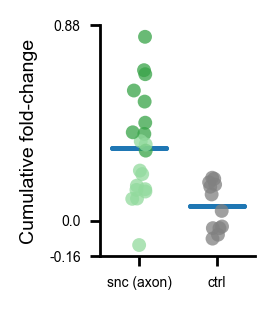

In [52]:
fig, ax = plt.subplots(1, figsize=(1, 1.5))
sns.pointplot(
    data=_plt_data_mouse.loc[
        (_plt_data_mouse["session_type"] == "stim")
        & (_plt_data_mouse["opsin"].isin(["chr2", "ctrl"]))
    ],
    ax=ax,
    ci=0,
    capsize=0.7,
    scale=0,
    **kwargs,
)
sns.stripplot(
    data=_plt_data_mouse.loc[
        (_plt_data_mouse["session_type"] == "stim")
        & (_plt_data_mouse["opsin"].isin(["chr2", "ctrl"]))
    ],
    ax=ax,
    alpha=0.75,
    jitter=.1,
    hue="mouse_id",
    palette=pal,
    # meanline=True,
    # pal=palette,
    **kwargs,
)
plt.legend().remove()
if "log2" in plt_variable:
    ax.set_ylabel("Cumulative fold-change")
    clean_ticks(ax, "y", precision=2, dtype=float, zero_symmetry=False)
elif "usage" in plt_variable:
    pass
else:
    ax.set_ylabel("Cumulative change in counts")
    clean_ticks(ax, "y", precision=-2, dtype=int, zero_symmetry=False)
# ax.set_ylabel("Cumulative change in\n target counts above baseline")
ax.set_xlabel("")
# ax.set_ylim(-75, 200)
# ax.set_yticks([-75, 0, 50])
sns.despine()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"reinforcement_summary_stim_barplot_learners_grouped-{plt_variable}",
    ),
    bbox_inches="tight",
)

In [53]:
params = {"compare_groups": ("snc (axon)", "ctrl"), "session_type": "stim"}

In [54]:
compare_groups = ["snc (axon)", "ctrl"]
compare_variables = [
    "change_count_cumulative_v2",
    "log2_fold_change_count_cumulative_v2",
]

In [55]:
cumulative_tests = {}

In [56]:
use_test = mannwhitneyu

In [57]:
for _group1 in compare_groups:
    for _group2 in compare_groups:
        comparison = f"{_group1}-{_group2}"
        cumulative_tests[comparison] = {}
        for _variable in compare_variables:

            cumulative_tests[comparison][_variable] = {}
            group1_dat = _plt_data_mouse.loc[
                (_plt_data_mouse["area"] == _group1)
                & (_plt_data_mouse["session_type"] == "stim")
            ][_variable]
            group2_dat = _plt_data_mouse.loc[
                (_plt_data_mouse["area"] == _group2)
                & (_plt_data_mouse["session_type"] == "stim")
            ][_variable]

            stat, p = use_test(
                group1_dat,
                group2_dat,
                alternative="greater",
            )
            cumulative_tests[comparison][_variable]["stat"] = stat
            cumulative_tests[comparison][_variable]["p"] = p

            cumulative_tests[comparison][_variable]["f"] = stat / (
                len(group1_dat) * len(group2_dat)
            )
            cumulative_tests[comparison][_variable]["n1"] = len(group1_dat)
            cumulative_tests[comparison][_variable]["n2"] = len(group2_dat)
            cumulative_tests[comparison][_variable][
                "n_definition"
            ] = "average learning per mouse"
            cumulative_tests[comparison][_variable]["test"] = str(use_test.__name__)

In [58]:
test_stats["mouse_totals"] = (
    _plt_data_mouse.groupby("area")["mouse_id"].nunique().to_dict()
)
test_stats["aggregate_usage_change"] = cumulative_tests

## break out by syllable

In [59]:
mouse_syllable_curves = plt_line.groupby(
    [
        "area",
        "target_syllable",
        "mouse_id",
        "opsin",
        "session_type",
        "bin_start",
        "learner",
    ]
).mean()
mouse_syllable_ints = mouse_syllable_curves.xs(
    (max_bins.loc[2], "stim", "chr2", "yes"),
    level=("bin_start", "session_type", "opsin", "learner"),
).copy()

/tmp/ipykernel_1655475/3653013295.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()


In [60]:
mouse_syllable_ints["syllable_name"] = mouse_syllable_ints.index.get_level_values(
    "target_syllable"
).map(syllable_aliases)
mouse_syllable_ints["class"] = mouse_syllable_ints.index.get_level_values(
    "target_syllable"
).map(syllable_map)

In [61]:
kwargs = {
    "data": mouse_syllable_ints.loc["snc (axon)"],
    "x": "syllable_name",
    "y": "log2_fold_change_count_cumulative_v2",
    "palette": sns.light_palette("green", n_colors=8)[2:],
}

In [62]:
order = (
    mouse_syllable_ints.loc["snc (axon)"]
    .groupby("syllable_name")[kwargs["y"]]
    .mean()
    .sort_values()
)
kwargs["order"] = order.index

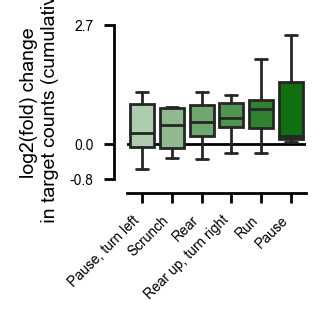

In [63]:
fig, ax = plt.subplots(1, figsize=(1.15, 1))
sns.boxplot(**kwargs)
ax.set_ylabel(aliases.get(ax.get_ylabel()))
ax.set_xlabel("")
ax.axhline(y=0, zorder=-200, color=plt.rcParams["axes.edgecolor"])
sns.despine(offset=5)
plt.xticks(rotation=45, ha="right")
clean_ticks(ax, "y", precision=1, zero_symmetry=False)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "learning_timecourse_persyllable_snc-chr2-learners"
    ),
)

In [64]:
kwargs = {
    "data": mouse_syllable_ints.loc["snc (axon)"],
    "x": "class",
    "y": "log2_fold_change_count_cumulative_v2",
    "palette": sns.light_palette("green", n_colors=3)[2:],
}

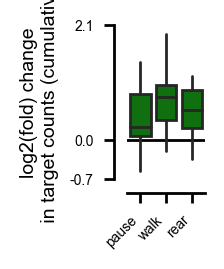

In [65]:
fig, ax = plt.subplots(1, figsize=(0.5, 1))
sns.boxplot(**kwargs, showcaps=False, showfliers=False)
ax.set_ylabel(aliases.get(ax.get_ylabel()))
ax.set_xlabel("")
ax.axhline(y=0, zorder=-200, color=plt.rcParams["axes.edgecolor"])
sns.despine(offset=5)
plt.xticks(rotation=45, ha="right")
clean_ticks(ax, "y", precision=1, zero_symmetry=False)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        "learning_timecourse_persyllableclass_snc-chr2-learners",
    ),
)

In [66]:
order = (
    mouse_syllable_ints.loc["snc (axon)"]
    .groupby("syllable_name")[kwargs["y"]]
    .mean()
    .sort_values()
)
kwargs["order"] = order.index

# Plot stim--post residuals

In [67]:
plt_variable = "change_count_cumulative_v2"

In [68]:
totals = (
    plt_line.xs(max_bin.loc[2], level="bin_start")
    .groupby(["area", "session_type", "mouse_id"])
    .mean()
).sort_index()

/tmp/ipykernel_1655475/3377119961.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [69]:
plt_areas = ["snc (axon)", "ctrl"]
pal = [geno_palette.snc, geno_palette.ctrl]

In [70]:
post = totals.xs("post", level="session_type")[plt_variable]
stim = totals.xs("stim", level="session_type")[plt_variable]

[('snc (axon)', '1528'), ('snc (axon)', '1529'), ('snc (axon)', '1544'), ('snc (axon)', '15822'), ('snc (axon)', '15823'), ('snc (axon)', '240'), ('snc (axon)', '3442'), ('snc (axon)', 'dls-ai32jr-1'), ('snc (axon)', 'dls-ai32jr-3')]
ctrl


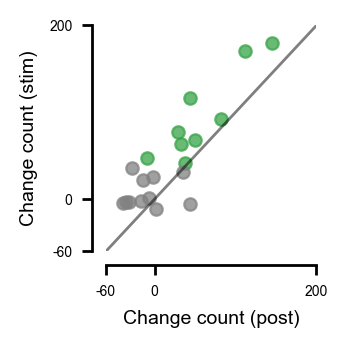

In [71]:
# simplified/merged plot
fig, ax = plt.subplots(1, figsize=(1.75, 1.75))
for _area, _color in zip(plt_areas, pal):
    if _area == "snc (axon)":
        idx = [("snc (axon)", _) for _ in use_mice.tolist()]
    else:
        idx = _area
    print(idx)
    ax.scatter(post.loc[idx], stim.loc[idx], color=_color, s=20, alpha=0.75)
sns.despine(offset=5)
# ax.set_ylim(-.3,1)
# ax.set_xlim(-.3,1)
ax.set_ylim(-60, 200)
ax.set_xlim(-60, 200)
ax.plot(ax.get_xlim(), ax.get_ylim(), color=plt.rcParams["axes.edgecolor"], alpha=0.5)

clean_ticks(ax, "y", precision=1, dtype=int, zero_symmetry=False)
clean_ticks(ax, "x", precision=1, dtype=int, zero_symmetry=False)
ax.set_xlabel("Change count (post)")
ax.set_ylabel("Change count (stim)")
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "reinforcement_savings_scatterplot_merge"),
    bbox_inches="tight",
)

In [72]:
result = {}
nshuffles = 1000

In [73]:
for _area in ["snc (axon)", "ctrl"]:
    if _area == "snc (axon)":
        idx = [("snc (axon)", _) for _ in use_mice.tolist()]
    else:
        idx = _area

    params = {}
    _result = pearsonr(post.loc[idx].values, stim.loc[idx].values)
    shuffle_rs = [
        pearsonr(post.loc[idx].values, shuffle(stim.loc[idx].values))[0]
        for i in range(nshuffles)
    ]
    shuffle_pval = (_result[0] < np.abs(shuffle_rs)).mean()
    result[_area] = {
        "r": _result[0],
        "pvalue": _result[1],
        "pvalue_shuffle": shuffle_pval,
        "area": _area,
        "test": pearsonr.__name__,
    }
    result[_area] = {**result[_area], **params}

In [74]:
test_stats["stim_post_usage_change_correlation"] = result

In [75]:
with open(test_statistics_file, "w") as f:
    toml.dump(dict(test_stats), f)